In [1]:
# load the dataset from kaggle

import kagglehub

# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'dog-and-cat-classification-dataset' dataset.
Path to dataset files: /kaggle/input/dog-and-cat-classification-dataset


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import os
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
def load_images_from_folder(folder, label, img_size=(64,64), max_images=2500):
    images, labels = [], []
    for i, filename in enumerate(os.listdir(folder)):
        if filename.endswith('.jpg'):
            try:
                img = Image.open(os.path.join(folder, filename)).convert('RGB')
                img = img.resize(img_size)
                images.append(np.array(img))
                labels.append(label)
            except:
                continue
        if max_images and i >= max_images-1:
            break
    return images, labels

img_size = (128, 128)

cat_images, cat_labels = load_images_from_folder(f'{path}/PetImages/Cat', 0, img_size=img_size)
dog_images, dog_labels = load_images_from_folder(f'{path}/PetImages/Dog', 1, img_size=img_size)

X = np.array(cat_images + dog_images)
y = np.array(cat_labels + dog_labels)

np.save('preprocessed_X.npy', X)
np.save('preprocessed_y.npy', y)

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [4]:
print(X.shape)
print(y.shape)

(5000, 128, 128, 3)
(5000,)


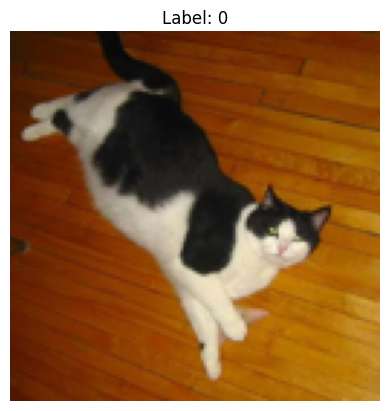

In [5]:
plt.imshow(X[4])
plt.title(f"Label: {y[2]}")
plt.axis('off')
plt.show()

In [6]:
#Normalize images from [0,255] to [0, 1]

X = np.load('preprocessed_X.npy')
y = np.load('preprocessed_y.npy')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the generator with common augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Just rescaling for validation

# Assuming X_train, y_train, X_val, y_val are numpy arrays of shape (samples, 128, 128, 3)
batch_size = 32

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val, y_val,
    batch_size=batch_size,
    shuffle=False
)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Build the CNN model
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu',kernel_initializer='he_uniform'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

for layer in base_model.layers:
    layer.trainable = False

opt = SGD(learning_rate=0.001, momentum=0.9)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
# Train the model
# Model training uses fit with generator objects
model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

model.save('cat_dog_classifier_VGG16.h5')

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_accuracy}')


# Save the trained model to disk

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 190ms/step - accuracy: 0.6018 - loss: 0.7054 - val_accuracy: 0.8350 - val_loss: 0.4353 - learning_rate: 0.0010
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - accuracy: 0.7316 - loss: 0.5270 - val_accuracy: 0.8460 - val_loss: 0.3754 - learning_rate: 0.0010
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - accuracy: 0.7604 - loss: 0.4848 - val_accuracy: 0.8350 - val_loss: 0.3769 - learning_rate: 0.0010
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.8014 - loss: 0.4399 - val_accuracy: 0.8680 - val_loss: 0.3205 - learning_rate: 0.0010
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - accuracy: 0.8027 - loss: 0.4347 - val_accuracy: 0.8770 - val_loss: 0.2968 - learning_rate: 0.0010
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - accuracy: 0.8165 - loss: 0.4059 - val_accuracy: 0.8770 - val_loss: 0.2888 - learning_rate: 0.0010
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.8

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.8487 - loss: 8.7076
Validation Accuracy: 0.8550000190734863
